In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from tools import inegi_projection, read_point_data, get_route_from_points, project_points_to_route
from preprocess import build_gdm_features
from shapely.geometry import LineString

In [2]:
posterior_distribution = pd.read_csv("data/posterior_params.csv")
gdm_estimates = pd.read_csv("data/gdm_estimates.csv")

outbound_route = get_route_from_points("data/outbound_route_points.csv")
inbound_route = get_route_from_points("data/inbound_route_points.csv")

stops = read_point_data("data/stops.csv")
stops["position"] = np.where(stops.leg == "outbound", project_points_to_route(stops, outbound_route), project_points_to_route(stops, inbound_route))
stops["distance_to_next"] = stops.groupby("leg").position.shift(-1) - stops.position

avg_speeds = pd.read_csv("data/mean_speeds.csv").set_index(["leg", "weekend", "hour", "origin"]).mean_speed

In [3]:
posterior_distribution.mean()

Unnamed: 0    2499.500000
beta__0          0.431879
beta__1          0.564152
precision        0.491365
dtype: float64

In [4]:
def speed_sim_factory(stops, avg_speeds, posterior_distribution):
    def speed_sim(weekend, hour, vehicles):
        last_stop = stops.iloc[np.searchsorted(stops.position, vehicles[:,0]) - 1]["stop_id"]
        avg_speed = avg_speeds.loc[(weekend, hour)].loc[last_stop].values
        posterior_sample = posterior_distribution.sample(vehicles.shape[0])
        _mean = posterior_sample["beta__0"] * avg_speed + posterior_sample["beta__1"] * vehicles[:, 1]
        _var = (1/posterior_sample["precision"].values)/2
        
        theta = _var/_mean
        k = _mean/theta
        sim = np.random.gamma(k, theta)
        sim[sim > 23.62] = 23.61
        return sim
    
    return speed_sim

In [5]:
from collections import OrderedDict
SEND_NOTHING = 0
SEND_OUTBOUND = 1
SEND_INBOUND = 2
SEND_BOTH = 3
AVAILABLE_ACTIONS = [SEND_NOTHING, SEND_OUTBOUND, SEND_INBOUND, SEND_BOTH]

class BusRouteSimulator(object):
    state_size = 19
    def __init__(self, 
                 speed_sim_outbound, speed_sim_inbound, 
                 outbound_length, inbound_length, 
                 avg_speeds_outbound, avg_speeds_inbound,
                 start_hour=5, end_hour=23):
        
        self.outbound_length = outbound_length
        self.inbound_length = inbound_length
        self.speed_sim_outbound = speed_sim_outbound
        self.speed_sim_inbound = speed_sim_inbound
        self.avg_speeds_outbound = avg_speeds_outbound
        self.avg_speeds_inbound = avg_speeds_inbound
        self.start_hour = start_hour
        self.end_hour = end_hour
        self.running = False
    
    def start(self, start_date, n_buses_outbound=5, n_buses_inbound=5):
        self.time = start_date.replace(hour=self.start_hour, minute=0, second=0)
        weekend = self.time.weekday() > 4
        
        self.waiting_outbound = n_buses_outbound
        self.moving_outbound = np.empty(shape=(0, 2))
        
        self.waiting_inbound = n_buses_inbound
        self.moving_inbound = np.empty(shape=(0, 2))
                
        self.running = True
    
    def end(self):
        self.time = None
        self.running = False
        
    def send_bus(self, waiting, moving, initial_speed):
        if waiting > 0:
            moving = np.append(moving, [(0.1, initial_speed)], axis=0)
            waiting = waiting - 1
        
        return waiting, moving
        
    def step(self, action):
        weekend = self.time.weekday() > 4
        hour = self.time.hour
        if not self.running:
            raise Exception("Simulation is not running!")
        
        if action not in AVAILABLE_ACTIONS:
            raise Exception("Invalid action")
            
        if action == SEND_OUTBOUND or action == SEND_BOTH:
            initial_speed = self.avg_speeds_outbound.loc[(weekend, hour)].iloc[0]
            (self.waiting_outbound, self.moving_outbound) = self.send_bus(self.waiting_outbound, self.moving_outbound, initial_speed)
        
        if action == SEND_INBOUND or action == SEND_BOTH:
            initial_speed = self.avg_speeds_inbound.loc[(weekend, hour)].iloc[0]
            (self.waiting_inbound, self.moving_inbound) = self.send_bus(self.waiting_inbound, self.moving_inbound, initial_speed)
        
        new_speeds_outbound = self.speed_sim_outbound(weekend, hour, self.moving_outbound)        
        self.moving_outbound[:, 0] = self.moving_outbound[:, 0] + new_speeds_outbound*60
        self.moving_outbound[:, 1] = new_speeds_outbound
        arrived = self.moving_outbound[:, 0] >= self.outbound_length
        self.moving_outbound = self.moving_outbound[~arrived]
        self.waiting_inbound += sum(arrived)
                
        new_speeds_inbound = self.speed_sim_inbound(weekend, hour, self.moving_inbound)
        self.moving_inbound[:, 0] = self.moving_inbound[:, 0] + new_speeds_inbound*60
        self.moving_inbound[:, 1] = new_speeds_inbound
        arrived = self.moving_inbound[:, 0] >= self.inbound_length
        self.moving_inbound = self.moving_inbound[~arrived]
        self.waiting_outbound += sum(arrived)
        
        self.time = self.time + pd.Timedelta(seconds=60)                
        reward = self.get_reward()                
        if self.time.hour >= self.end_hour:
            self.end()
        state = self.get_state()
            
        return state, reward
    
    def get_state(self):
        if not self.running:
            return {}
        
        outbound_distances = np.diff(sorted([0, *self.moving_outbound[:,0], self.outbound_length]))
        inbound_distances = np.diff(sorted([0, *self.moving_inbound[:,0], self.inbound_length]))
        speeds = np.concatenate([self.moving_outbound[:, 1], self.moving_inbound[:, 1]])
        total_buses = self.waiting_outbound + self.waiting_inbound + len(self.moving_outbound) + len(self.moving_inbound)
        state_dict = OrderedDict([
            ("waiting_out", self.waiting_outbound/total_buses),
            ("waiting_in", self.waiting_inbound/total_buses),
            ("moving_out", len(self.moving_outbound)/total_buses),
            ("moving_in", len(self.moving_inbound)/total_buses),
            ("closest_outbound", min([self.outbound_length, *self.moving_outbound[:,0]])/self.outbound_length),
            ("closest_inbound", min([self.inbound_length, *self.moving_inbound[:,0]])/self.inbound_length),
            ("farthest_outbound", max([0, *self.moving_outbound[:,0]])/self.outbound_length),
            ("farthest_inbound", max([0, *self.moving_inbound[:,0]])/self.inbound_length),
            ("mean_dist_outbound", outbound_distances.mean()/self.outbound_length),
            ("mean_dist_inbound", inbound_distances.mean()/self.inbound_length),
            ("min_dist_outbound", outbound_distances.min()/self.outbound_length),
            ("min_dist_inbound", inbound_distances.min()/self.inbound_length),
            ("max_dist_outbound", outbound_distances.max()/self.outbound_length),
            ("max_dist_inbound", inbound_distances.max()/self.inbound_length),
            ("none_out", 1 if self.waiting_outbound == 0 else 0),
            ("none_in", 1 if self.waiting_inbound == 0 else 0),
            ("mean_speed", speeds.mean() if speeds.shape[0] else 0),
            ("mean_speed_outbound", self.moving_outbound[:,1].mean() if self.moving_outbound.shape[0] else 0),
            ("mean_speed_inbound", self.moving_inbound[:,1].mean() if self.moving_inbound.shape[0] else 0),
            ("hour_minute", self.time.hour + self.time.minute/60)
        ])
        
        return state_dict
    
    def get_reward(self):
        outbound_distances = np.diff(sorted([0, *self.moving_outbound[:,0], self.outbound_length]))
        inbound_distances = np.diff(sorted([0, *self.moving_inbound[:,0], self.inbound_length]))
        return -max(max(outbound_distances)/self.outbound_length, max(inbound_distances)/self.inbound_length)

In [6]:
stops_out = stops[stops.leg=="outbound"]
stops_in = stops[stops.leg=="inbound"]
speed_sim_out = speed_sim_factory(stops_out, avg_speeds.loc["outbound"], posterior_distribution)
speed_sim_in = speed_sim_factory(stops_in, avg_speeds.loc["inbound"], posterior_distribution)
outbound_length = stops_out.position.max()
inbound_length = stops_in.position.max()
route = BusRouteSimulator(speed_sim_out, speed_sim_in, outbound_length, inbound_length, avg_speeds.loc["outbound"], avg_speeds.loc["inbound"])

def run_episode(route, agent, start=datetime.now()):
    route.start(datetime.now())
    s, r = route.step(SEND_BOTH)
    ss = [s]
    rs = [r]
    while route.running:
        action = agent.choose_action(s)
        s, r = route.step(action)
        rs.append(r)
        ss.append(s)
    return np.array(rs), ss

/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


-0.9935389276334534


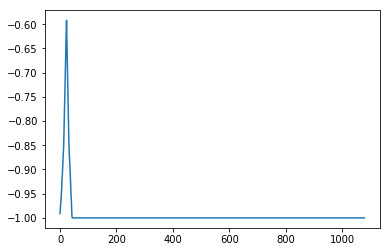

In [7]:
import random
from datetime import datetime
start = datetime(year=2018, month=3, day=9, hour=5)
class WorstAgent(object):
    def choose_action(self, state):
        return SEND_NOTHING

worst_rewards, _ = run_episode(route, WorstAgent(), start=start)
plt.plot(np.arange(len(worst_rewards)), worst_rewards)
print(worst_rewards.mean())

/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


-0.6368301613929493


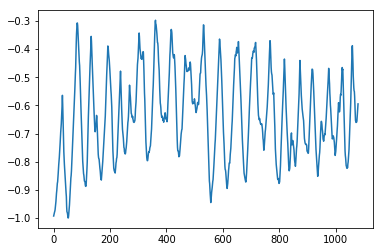

In [8]:
class RandomAgent(object):
    def choose_action(self, state):
        action = random.sample(AVAILABLE_ACTIONS, 1)[0]
        return action
    

random_rewards, _ = run_episode(route, RandomAgent(), start=start)
plt.plot(np.arange(len(random_rewards)), random_rewards)
print(random_rewards.mean())

/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


-0.485681490228274

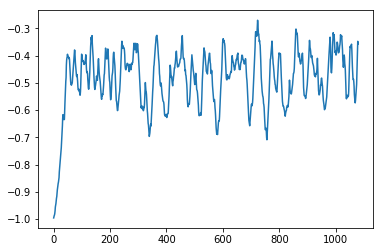

In [9]:
# The base policy agent, triggers a bus departure from each terminal 
#  if there is at least one available and more than `self.interval` minutes have passed since the last departure from that terminal
class BaseAgent(object):
    def __init__(self, interval=15):
        self.last_out = 0
        self.last_in = 0
        self.interval = interval
        
    def send_or_not(self, last, waiting):
        return (last is None or last > self.interval) and waiting > 0
    def choose_action(self, state):
        send_out = self.send_or_not(self.last_out, state["waiting_out"])
        if send_out:
            self.last_out = 0
        elif self.last_out is not None:
            self.last_out += 1
        
        send_in = self.send_or_not(self.last_in, state["waiting_in"])
        if send_in:
            self.last_in = 0
        elif self.last_in is not None:
            self.last_in += 1
        
        if send_out and send_in:
            action = SEND_BOTH
        elif send_out:
            action = SEND_OUTBOUND
        elif send_in:
            action = SEND_INBOUND
        else:
            action = SEND_NOTHING
        
        return action
    
base_rewards, base_states = run_episode(route, BaseAgent(10), start=start)
plt.plot(np.arange(len(base_rewards)), base_rewards)
np.mean(base_rewards)

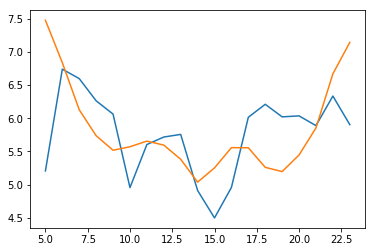

In [10]:
# Sanity check, simulated mean speeds should be somewhat similar to computed speeds

states = pd.DataFrame(base_states).dropna()
states["hour"] = states.hour_minute.map(round)
sbyh = states.groupby("hour").mean_speed.mean()
plt.plot(sbyh.index, sbyh)
gbyh = avg_speeds.groupby("hour").mean()
gbyh = gbyh[5:]
plt.plot(gbyh.index, gbyh)

In [11]:
from qnetwork import QNetwork, Memory
# Populates the memory for experience replay purposes
state_size = 20
mem_size = 1000000
static_memory = Memory(max_size=mem_size)
env = route
p = [0.25, 0.25, 0.25, 0.25]
# Do random shit for a while
pre_train_eps = 4
for i in range(pre_train_eps):
    print("Episode {}".format(i))
    env.start(start_date=start)
    env.step(SEND_BOTH)
    total_reward = 0
    while env.running:
        state = env.get_state()
        oh_action = np.random.multinomial(1, p)
        action = AVAILABLE_ACTIONS[oh_action.argmax()]
        next_state, reward = env.step(action)
        
        state = np.fromiter(state.values(), float)
        assert np.isnan(state).sum() == 0
        if not env.running:
            next_state = np.zeros(state_size)
        else:
            next_state = np.fromiter(next_state.values(), float)
        total_reward += reward
        static_memory.add((state, action, reward, next_state))
    
    print("Total Reward: {}".format(total_reward))


/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Episode 0


/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


Total Reward: -737.4471792973284
Episode 1
Total Reward: -705.4722358863346
Episode 2
Total Reward: -674.4118082155363
Episode 3
Total Reward: -599.030522637251


In [12]:
# Q-network hyperparameters
train_episodes = 200
hidden_size = 1024 # Size of each hidden layer
learning_rate=0.0001
gamma = 0.99

# Training parameters
explore_p = 0.05 # Probability of taking a random action
train_every = 4
copy_every = 1080 # The main network will be cloned after this number of steps
batch_size=32


# Display parameters
print_every = 10
plot_every = 50
save_every = 100
roll_window = int(round(plot_every/4))

/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


Best reward -848.33
Best reward -698.14
Best reward -620.68
Episode: 10 Last episode reward: -769.97 Mean episode reward (Last 12): -782.00 Mean loss (Last 5k): 0.0476
Best reward -616.86
Best reward -601.29
Episode: 20 Last episode reward: -724.19 Mean episode reward (Last 12): -671.26 Mean loss (Last 5k): 0.0436
Episode: 30 Last episode reward: -705.65 Mean episode reward (Last 12): -670.72 Mean loss (Last 5k): 0.0587
Best reward -587.83
Best reward -575.00
Episode: 40 Last episode reward: -620.93 Mean episode reward (Last 12): -633.11 Mean loss (Last 5k): 0.1027
Best reward -561.97
Episode: 50 Last episode reward: -615.76 Mean episode reward (Last 12): -623.51 Mean loss (Last 5k): 0.1505


/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:93: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()


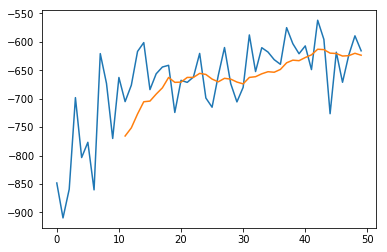

/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:97: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()


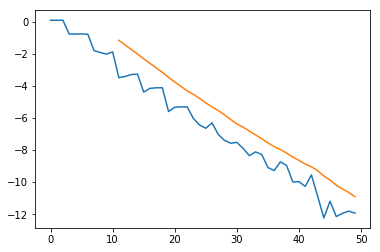

Best reward -546.71
Episode: 60 Last episode reward: -561.81 Mean episode reward (Last 12): -593.40 Mean loss (Last 5k): 0.2389
Best reward -546.17
Episode: 70 Last episode reward: -595.26 Mean episode reward (Last 12): -595.61 Mean loss (Last 5k): 0.3175
Best reward -540.15
Best reward -522.06
Episode: 80 Last episode reward: -612.40 Mean episode reward (Last 12): -568.99 Mean loss (Last 5k): 0.4885
Episode: 90 Last episode reward: -582.45 Mean episode reward (Last 12): -586.34 Mean loss (Last 5k): 0.6001
Episode: 100 Last episode reward: -680.61 Mean episode reward (Last 12): -576.66 Mean loss (Last 5k): 0.8088


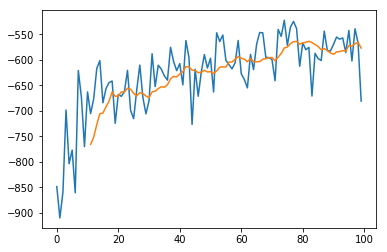

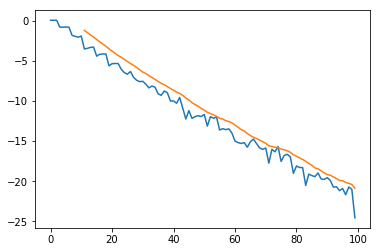

Best reward -515.48
Episode: 110 Last episode reward: -567.08 Mean episode reward (Last 12): -630.37 Mean loss (Last 5k): 0.8598
Episode: 120 Last episode reward: -629.51 Mean episode reward (Last 12): -595.49 Mean loss (Last 5k): 0.9044
Episode: 130 Last episode reward: -524.09 Mean episode reward (Last 12): -592.79 Mean loss (Last 5k): 1.0572
Episode: 140 Last episode reward: -618.97 Mean episode reward (Last 12): -577.83 Mean loss (Last 5k): 1.0959
Episode: 150 Last episode reward: -538.18 Mean episode reward (Last 12): -582.32 Mean loss (Last 5k): 1.1731


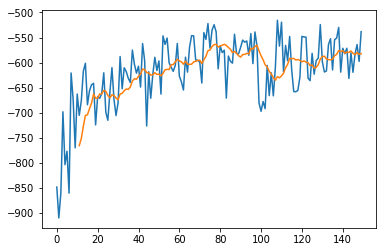

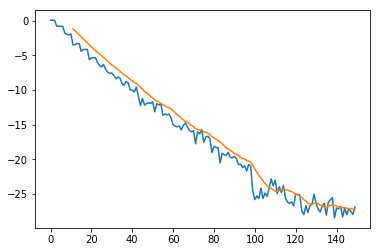

Episode: 160 Last episode reward: -555.83 Mean episode reward (Last 12): -575.77 Mean loss (Last 5k): 1.2659
Episode: 170 Last episode reward: -567.00 Mean episode reward (Last 12): -579.32 Mean loss (Last 5k): 1.2687
Episode: 180 Last episode reward: -644.36 Mean episode reward (Last 12): -639.18 Mean loss (Last 5k): 1.4466
Episode: 190 Last episode reward: -670.96 Mean episode reward (Last 12): -675.09 Mean loss (Last 5k): 1.6130


In [13]:
import tensorflow as tf
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate, state_size=state_size)
cloneQN = QNetwork(name='clone', hidden_size=hidden_size, learning_rate=learning_rate, state_size=state_size)
memory = Memory(max_size=mem_size)
memory.buffer = static_memory.buffer.copy()
saver = tf.train.Saver()
rewards_list = []
mean_Qs = []
losses = []
action_counts = [0]*len(AVAILABLE_ACTIONS)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Initialize the clone with same weights as the main
    main_vars = tf.trainable_variables("main")
    clone_vars = tf.trainable_variables("clone")
    copy = [c.assign(m.value()) for m, c in zip(main_vars, clone_vars)]
    sess.run(copy)
    step = 0
    for ep in range(1, train_episodes):
        env.start(start_date=start)
        env.step(SEND_BOTH) # Get stuff moving
        episode_reward = 0
        episode_Qs = []
        while env.running:
            step += 1
            state = env.get_state()
            if explore_p > np.random.rand():
                action = list(np.random.multinomial(1, p)).index(1)
                action_counts[action] += 1
            else:
                # Use main network to choose an action
                feed = {mainQN.inputs_: [np.fromiter(state.values(), float)]}
                Qs = sess.run(mainQN.output, feed_dict=feed)[0]
                episode_Qs.extend(Qs)
                action = np.argmax(Qs)
                action_counts[action] += 1
            
            state = np.fromiter(state.values(), float)
            assert np.isnan(state).sum() == 0
            next_state, reward = env.step(action)
            if not env.running:
                next_state = np.zeros(state_size)
            else:
                next_state = np.fromiter(next_state.values(), float)
                             
            episode_reward += reward
            memory.add((state, action, reward, next_state))
            if ep % train_every == 0:
                batch = np.array(memory.sample(batch_size))
                states = np.array(batch[:, 0].tolist())
                actions = batch[:, 1].tolist()
                rewards = batch[:, 2]
                next_states = np.array(batch[:, 3].tolist())

                # Use the main to choose actions, and the clone to evaluate them (DDQN)
                main_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
                clone_Qs = sess.run(cloneQN.output, feed_dict={cloneQN.inputs_: next_states})
                target_Qs = clone_Qs[np.arange(clone_Qs.shape[0]), np.argmax(main_Qs, axis=1)]
                targets = rewards + gamma * target_Qs

                # At the final state, set the targets to the rewards
                final = [sum(next_state) == 0 for next_state in next_states]
                targets[final] = rewards[final]

                loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                  feed_dict = {
                                      mainQN.inputs_: states,
                                      mainQN.targetQs_: targets,
                                      mainQN.actions_: actions
                                  })
                losses.append(loss)
            
            # Copy the main network into the clone every `copy_every` steps
            if step % copy_every == 0:
                main_vars = tf.trainable_variables("main")
                clone_vars = tf.trainable_variables("clone")
                copy = [c.assign(m.value()) for m, c in zip(main_vars, clone_vars)]
                sess.run(copy)
            
        mean_Qs.append(sum(episode_Qs)/len(episode_Qs))
        rewards_list.append(episode_reward)        
        if ep % print_every == 0:
            r_mean = sum(rewards_list[-roll_window:])/min(roll_window, len(rewards_list))
            print("Episode: {}".format(ep),
                  "Last episode reward: {:,.2f}".format(episode_reward),
                  "Mean episode reward (Last {}): {:,.2f}".format(roll_window, r_mean),
                  "Mean loss (Last 5k): {:,.4f}".format(sum(losses[-5000:])/min(5000, len(losses))))
        
        if ep % plot_every == 0:
            rr = pd.Series(rewards_list)
            plt.plot(rr.index, rr)
            plt.plot(rr.index, pd.rolling_mean(rr, roll_window))
            plt.show()
            qq = pd.Series(mean_Qs)
            plt.plot(qq.index, qq)
            plt.plot(qq.index, pd.rolling_mean(qq, roll_window))
            plt.show()
        
        if ep % save_every == 0:
            saver.save(sess, "checkpoints/qnetwork.ckpt")
        if episode_reward == max(rewards_list):
            print("Best reward {:,.2f}".format(episode_reward))
            saver.save(sess, "best_qnet/qnetwork.ckpt")
            
    saver.save(sess, "checkpoints/qnetwork.ckpt")

/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


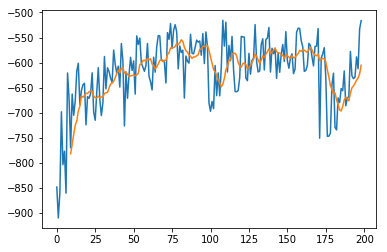

count    199.000000
mean    -617.606539
std       66.860548
min     -909.788758
25%     -653.434815
50%     -609.691707
75%     -569.137316
max     -515.484553
dtype: float64


/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
  


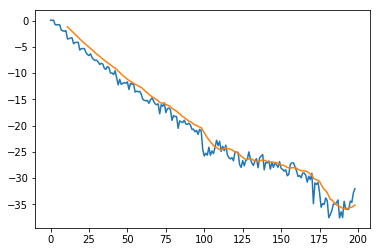

count    199.000000
mean     -20.320827
std       10.274578
min      -37.611771
25%      -27.966017
50%      -22.804390
75%      -11.965811
max        0.086401
dtype: float64


-516.3589524499286

In [14]:
rr = pd.Series(rewards_list)
plt.plot(rr.index, rr)
plt.plot(rr.index, pd.rolling_mean(rr, 10))
plt.show()
print(rr.describe())
qq = pd.Series(mean_Qs)
plt.plot(qq.index, qq)
plt.plot(qq.index, pd.rolling_mean(qq, roll_window))
plt.show()
print(qq.describe())
rr.values[-1]

INFO:tensorflow:Restoring parameters from best_qnet_beats12/qnetwork.ckpt


/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


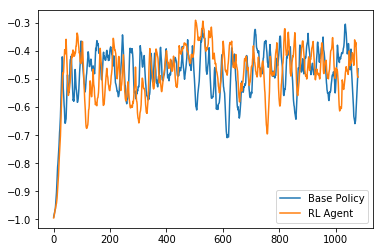

-520.9611460662848
-514.943550409072


In [20]:
# An agent implementing the policy that maximizes the estimated action-value (no exploring)
class RLAgent(object):
    def __init__(self, qnetwork):
        self.qnetwork = qnetwork
        self.first = True
    def choose_action(self, state):
        if not self.first:
            feed = {self.qnetwork.inputs_: [list(state.values())]}
            Qs = sess.run(self.qnetwork.output, feed_dict=feed)
            action = np.argmax(Qs)
        else:
            action = SEND_BOTH
            self.first = False
        return action
    
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('best_qnet_beats12'))
    rl_rewards, _ = run_episode(route, RLAgent(mainQN), start=start)
base_rewards, _ = run_episode(route, BaseAgent(12), start=start)
plt.plot(np.arange(len(rl_rewards)), base_rewards, label="Base Policy")
plt.plot(np.arange(len(rl_rewards)), rl_rewards, label="RL Agent")
plt.legend()
plt.show()
print(sum(base_rewards))
print(sum(rl_rewards))

In [21]:
rl_rewards = []
base_rewards = []
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('best_qnet_beats12'))
    for i in range(100):
        r, _ = run_episode(route, RLAgent(mainQN), start=start)
        rl_rewards.append(r)
        r, _ = run_episode(route, BaseAgent(10), start=start)
        base_rewards.append(r)

INFO:tensorflow:Restoring parameters from best_qnet_beats12/qnetwork.ckpt


/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


Text(0,0.5,'Count')

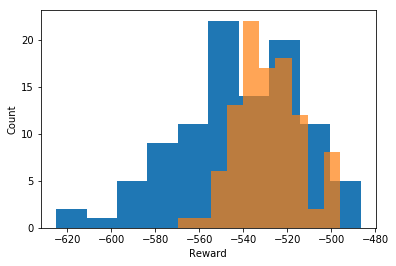

In [22]:
plt.hist(np.array(base_rewards).sum(axis=1), bins=10, alpha=1)
plt.hist(np.array(rl_rewards).sum(axis=1), bins=10, alpha=0.7)
plt.xlabel("Reward")
plt.ylabel("Count")

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
start = datetime(year=2017, month=12, day=20, hour=5)

# A function to render an episode produced by the environment `env` and the agent `agent`
speeds = []
def sim_episode(env, agent, start=None):
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(17)
    ax.axis('off')
    ax.plot(*outbound_route.xy)
    ax.plot(*inbound_route.xy)
    env.start(start_date=start)
    env.step(SEND_BOTH)
    speeds_out = list(env.moving_outbound[:, 1]) + [0]*env.waiting_outbound
    speeds_in = list(env.moving_inbound[:, 1]) + [0]*env.waiting_inbound
    speeds.append((speeds_out, speeds_in))
    points_out = [outbound_route.interpolate(bus) for bus in list(env.moving_outbound[:,0]) + [0]*env.waiting_outbound]
    points_in = [inbound_route.interpolate(bus) for bus in list(env.moving_inbound[:,0]) + [0]*env.waiting_inbound]
    points = points_out + points_in
    scatter = ax.scatter([p.x for p in points], [p.y for p in points], color="red", animated=True)
    def animate(i):    
        if env.running:
            speeds_out = list(env.moving_outbound[:, 1]) + [0]*env.waiting_outbound
            speeds_in = list(env.moving_inbound[:, 1]) + [0]*env.waiting_inbound
            speeds.append((speeds_out, speeds_in))            
            points_out = [outbound_route.interpolate(bus) for bus in list(env.moving_outbound[:,0]) + [0]*env.waiting_outbound]
            points_in = [inbound_route.interpolate(bus) for bus in list(env.moving_inbound[:,0]) + [0]*env.waiting_inbound]
            points = points_out + points_in
            if len(points) > 0:
                scatter.set_offsets([[p.x, p.y] for p in points])
            ax.set_title("Time: {} Reward: {:2f}".format(env.time, env.get_reward()))
            action = agent.choose_action(env.get_state())
            env.step(action)
        return scatter, ax

    anim = FuncAnimation(fig, animate, frames=np.arange(0, 1080), interval=100)
    return anim


/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:59: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/arinarmo/.pyenv/versions/3.5.4/envs/thesis/lib/python3.5/site-packages/ipykernel

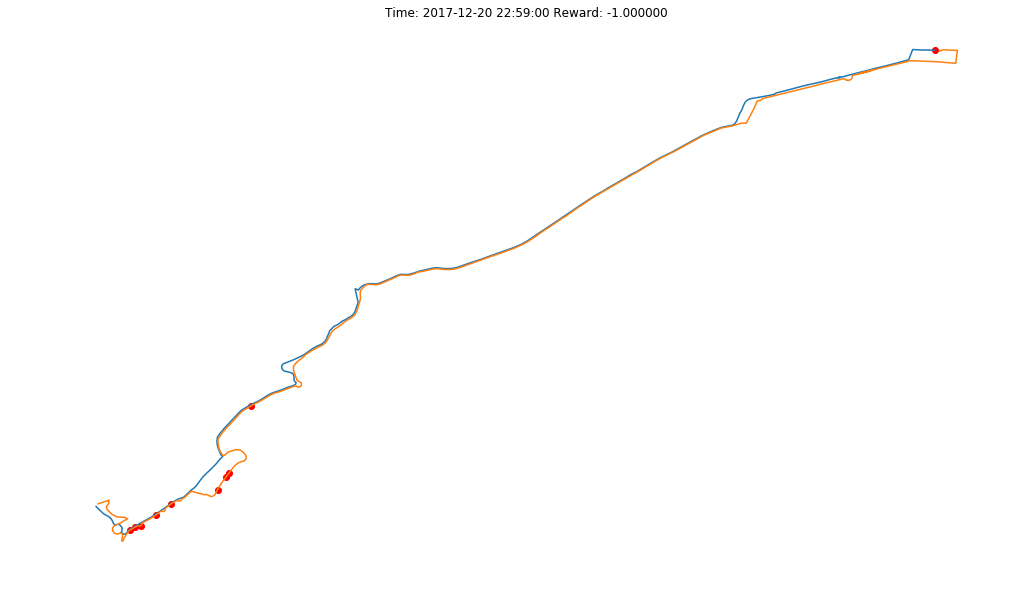

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    rl_sim = sim_episode(route, RLAgent(mainQN), start=start)
    HTML(rl_sim.to_html5_video()) 
    rl_sim.save('rl_agent.mp4')


